In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from src.tags_helpers.tag_grouper import TagGrouper
from src.tags_helpers.graph_plotting import describe_graph, plot_degree_distribution

# Automatic reloading of modules
%load_ext autoreload
%autoreload 2

# Import the data around COP21

In [3]:
file_name = 'data/climate_videos_v3.jsonl'
df = pd.read_json(file_name, lines=True)
df['upload_date'] = pd.to_datetime(df['upload_date'])
df.set_index('upload_date', inplace=True)
df.sort_index(inplace=True)
# df = df.loc['2015-12-01': '2015-12-31']
print(len(df))
# df = df.iloc[59999:]
df.reset_index(inplace=True)
df.set_index('display_id', inplace=True)
display(df)

70231


,upload_date,categories,channel_id,crawl_date,description,dislike_count,duration,like_count,tags,title,view_count,classification_categories
display_id,,,,,,,,,,,,
rXVcnciIduc,2006-05-23,Howto & Style,UC5MOW8BO3dH38Fo3Rau17KQ,2019-11-02 01:19:20.939142,Water vapour is the primary greenhouse gas.,0.0,61,8.0,"science,climatechange,weather",Professor Tim Palmer on climate change,1644,{'/Science/Ecology & Environment/Climate Chang...
UhVk4R_T7O8,2006-06-07,News & Politics,UCy1UzIJf_Dog0vzLJUPLXHA,2019-11-03 12:38:39.986280,"The DuPont plant in DeLisle, Mississippi has b...",6.0,1713,48.0,"dioxin,duplicity,dupont,sierra,club,chronicles...","Dioxin, Duplicity & Dupont - Sierra Club Chron...",7399,{'/People & Society/Social Issues & Advocacy/G...
RUjM59H3fYk,2006-07-19,News & Politics,UC61qQBrHiNKprDXW5ZnLPyQ,2019-11-03 07:02:08.742306,HotAir.com's Michelle Malkin jumps! to fight g...,104.0,199,192.0,"global,warming,environment,world,jump,day,mich...",VENT Jump!,61816,{'/Science/Ecology & Environment/Climate Chang...
MvTaLdk3-dE,2006-09-07,Howto & Style,UC5MOW8BO3dH38Fo3Rau17KQ,2019-11-02 01:19:20.354547,Hear from the people behind the BBC's global c...,1.0,146,6.0,"science,climate,global,warming,distributed,tem...",What might the climate be in 2053?,1092,{'/Science/Ecology & Environment/Climate Chang...
6otdzD8ncnw,2006-09-22,Music,UCNia_X3a7HLxBSN-z57UGQw,2019-11-04 22:29:01.019235,Musician G. Love and NRDC's Dan Lashof drop rh...,2.0,184,1.0,"nrdc,environment,music,g.love,globalwarming,en...",NRDC at Bonnaroo -- Solve Global Warming!,1033,{'/People & Society/Social Issues & Advocacy/G...
...,...,...,...,...,...,...,...,...,...,...,...,...
KbPSHpvESUQ,2019-10-03,News & Politics,UC0xLyicoeOd6KsNbl1Qst1g,2019-11-17 23:55:08.183852,"For the latest news across Belize, visit:\nhtt...",0.0,101,0.0,,Minister of Environment Says Funds for New Riv...,127,{'/People & Society/Social Issues & Advocacy/G...
jEEvxNe_CpA,2019-10-03,News & Politics,UC0xLyicoeOd6KsNbl1Qst1g,2019-11-17 23:55:07.556218,"For the latest news across Belize, visit:\nhtt...",0.0,45,1.0,,What’s Up with the Bay?,57,{'/People & Society/Social Issues & Advocacy/G...
uZLWfoHhf0M,2019-10-03,Nonprofits & Activism,UCRYjOhn_GeNtZjz4TY1OJEg,2019-11-22 08:41:39.062487,"Untrashing Djulpan – A Sea Shepherd Film.\n\n""...",0.0,1509,308.0,"Sea Shepherd,Marine Conservation,SSCS,ocean,co...",Untrashing Djulpan,4156,{'/People & Society/Social Issues & Advocacy/G...


# Map tags to a smaller subset

In [4]:
data = df['tags'].copy()
tag_grouper = TagGrouper()
# tag_grouper.reset_cache()
# 
# # Manually add specific tags
# tag_grouper.get('news')
# tag_grouper.get('cop21')
# tag_grouper.tags_mapping['breaking news'] = 'news'
# tag_grouper.tags_mapping["2015 united nations climate change conference"] = "cop21"

tqdm.pandas()
data = data.apply(lambda tags: tags.split(','))
data = data.progress_apply(lambda tags: [tag for tag in tags if tag != ''])
data = data[data.progress_apply(lambda tags: len(tags) > 0)]
data = data.progress_apply(lambda tags: [tag_grouper.get(tag) for tag in tags])
tag_grouper.save()
data

100%|██████████| 65434/65434 [00:00<00:00, 82990.30it/s] 


display_id
rXVcnciIduc                    [science, climatechange, weather]
UhVk4R_T7O8    [dioxin, duplicity, duplicity, sierra, club, c...
RUjM59H3fYk    [global, warming, environment, world, jump, da...
MvTaLdk3-dE    [science, climatechange, global, warming, dist...
6otdzD8ncnw    [nrdc, environment, music, g.love, warming, en...
                                     ...                        
lZFBb6nOUyk    [carbon, lee myung-bak, too big to fail, bigba...
f9d7vRgiTjc    [water solar panels, coal-fired power plant, p...
uZLWfoHhf0M    [syed naseer ahmad, conservation, svs, oregon,...
XPSYzLZ7xKU    [seeker, science, crisis, extinctions, planet,...
WDo1uVuJmkg    [time magazine, robbie thorpe, agriculture, gl...
Name: tags, Length: 65434, dtype: object

# Take a look at the tag counts

/home/sebastien/miniconda3/envs/2023/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 3484 (\N{SINHALA LETTER ALPAPRAANA GAYANNA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sebastien/miniconda3/envs/2023/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Matplotlib currently does not support Sinhala natively.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sebastien/miniconda3/envs/2023/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 3540 (\N{SINHALA VOWEL SIGN KETTI PAA-PILLA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sebastien/miniconda3/envs/2023/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 3499 (\N{SINHALA LETTER MUURDHAJA NAYANNA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sebastien/miniconda3/envs/2023/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: 

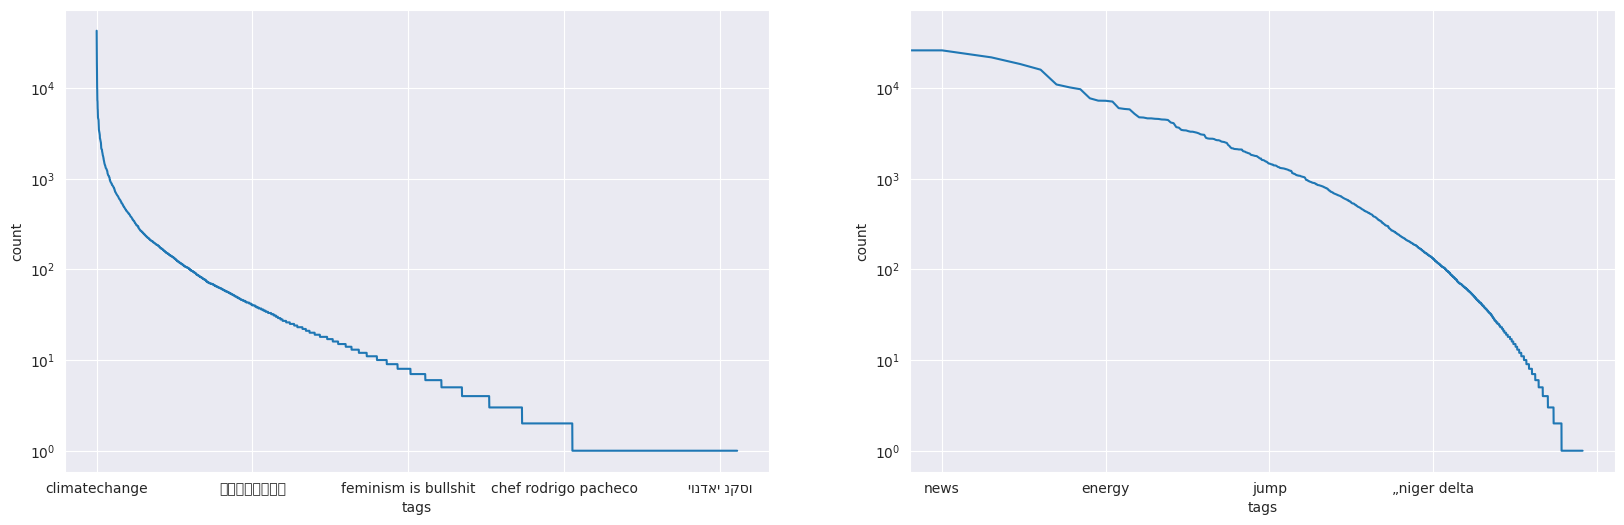

climatechange                       42701
news                                25931
pollution                           21710
environment                         18329
warming                             15880
                                    ...  
e568e731142e0171ea0160151e3f6566        1
87f2c94522363822fe03c86a5d4ef24a        1
924b76d57d3ecf86681d5a73779f23ff        1
4b125b919e5e0794e44bb311c8e4ec17        1
vyvyan james hope-scott                 1
Length: 8224, dtype: int64

In [5]:
tags_count = pd.Series(dict(Counter(tag for tags in data for tag in tags)))
tags_count.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
tags_count.plot(xlabel='tags', ylabel='count', ax=ax[0], logy=True, logx=False, grid=True)
tags_count.plot(xlabel='tags', ylabel='count', ax=ax[1], logy=True, logx=True, grid=True)
plt.show()
tags_count

# Only keep the top 90th percentile of tags 

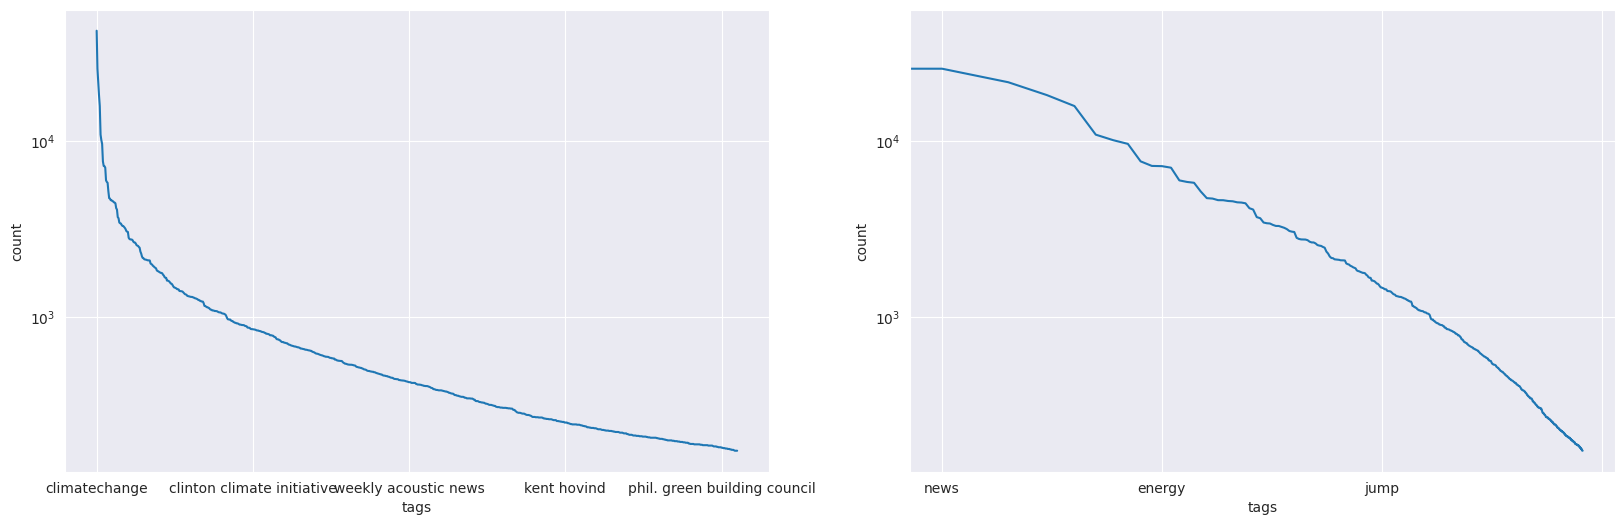

climatechange                                       42701
news                                                25931
pollution                                           21710
environment                                         18329
warming                                             15880
                                                    ...  
15th delhi sustainable development summit begins      173
woolworths holdings limited (business operation)      172
wgbh                                                  172
sulfur                                                172
cam winton                                            172
Length: 821, dtype: int64

In [6]:
threshold = tags_count.quantile(0.9)
common_tags_count = tags_count[tags_count > threshold]
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
common_tags_count.plot(xlabel='tags', ylabel='count', ax=ax[0], logy=True, logx=False, grid=True)
common_tags_count.plot(xlabel='tags', ylabel='count', ax=ax[1], logy=True, logx=True, grid=True)
plt.show()
common_tags_count

                               count
upload_date                         
1970-01-01 00:00:01.116892800      1
1970-01-01 00:00:01.120348800      1
1970-01-01 00:00:01.121299200      6
1970-01-01 00:00:01.121385600     12
1970-01-01 00:00:01.121558400     25
...                              ...
1970-01-01 00:00:01.573862400      2
1970-01-01 00:00:01.573948800      2
1970-01-01 00:00:01.574035200      3
1970-01-01 00:00:01.574121600      2
1970-01-01 00:00:01.574208000      3

[5136 rows x 1 columns]
                count
upload_date          
1970-01-01   72924794


100%|██████████| 64629/64629 [00:00<00:00, 684208.11it/s]


<Axes: xlabel='upload_date'>

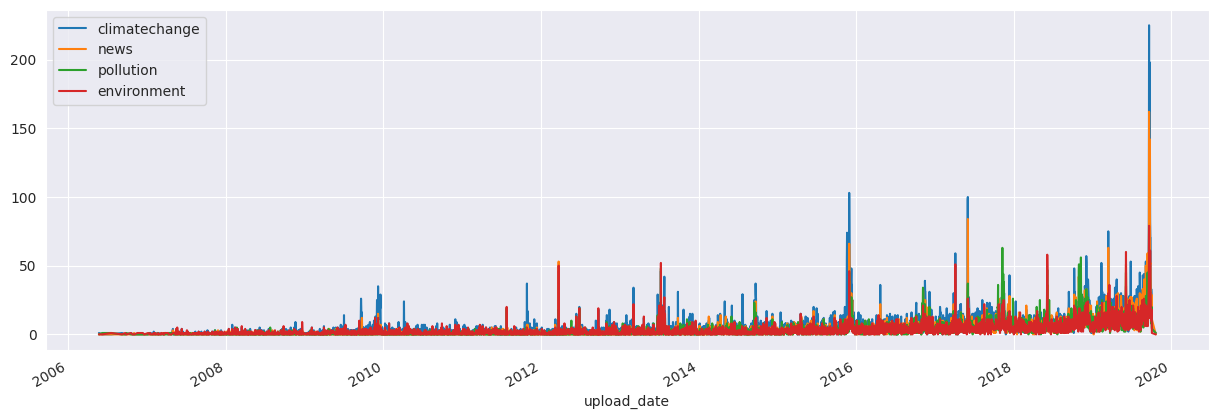

In [29]:
year_data = pd.DataFrame(data)
year_data = year_data.merge(pd.to_datetime(df['upload_date']), left_index=True, right_index=True)

nb_video_by_date = pd.read_json('data/nb_videos_by_date.jsonl', lines=True)
nb_video_by_date['upload_date'] = pd.to_datetime(nb_video_by_date['upload_date'] / 1000)
nb_video_by_date.set_index('upload_date', inplace=True)
print(nb_video_by_date)
nb_video = nb_video_by_date.resample('D').sum()
print(nb_video)

top_tags = list(common_tags_count.index)[:4]
for tag in top_tags:
    year_data[tag] = data.progress_apply(lambda x: int(tag in x))

year_data.groupby('upload_date')[top_tags].sum().plot(figsize=(15, 5))

# Filter the tags in the dataframe

In [8]:
videos = list(data.index)
common_tags = set(common_tags_count.index)
data = data.apply(lambda x: [tag for tag in x if tag in common_tags])
data = data[data.progress_apply(lambda tags: len(tags) > 0)]

100%|██████████| 65434/65434 [00:00<00:00, 1100622.35it/s]


# Create the bipartite graph between videos and tags

In [9]:
G = nx.Graph()
G.add_nodes_from(common_tags, bipartite=0)
G.add_nodes_from(videos, bipartite=1)

for video, tags in tqdm(data.items(), total=len(data)):
    for tag in tags:
        G.add_edge(video, tag)
print(G)

100%|██████████| 64629/64629 [00:00<00:00, 70742.63it/s]

Graph with 66255 nodes and 654634 edges


# Plot a subgraph to visualize the data

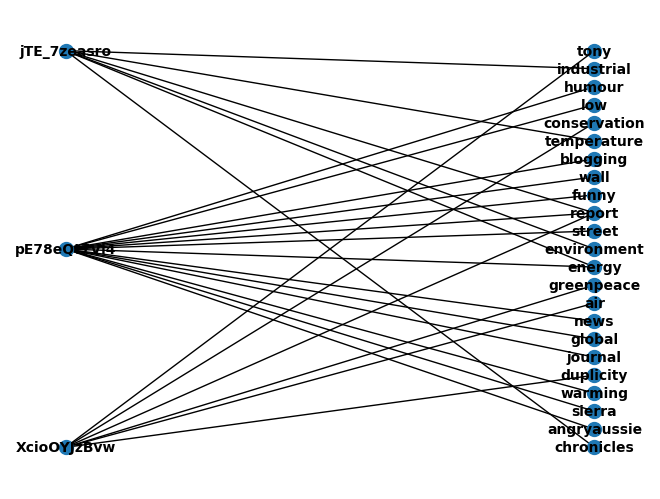

In [10]:
sub_videos = videos[8:11].copy()
sub_tags = []
for node in sub_videos:
    sub_tags.extend(list(G.neighbors(node)))
    
sub_nodes = sub_videos + sub_tags
subgraph = G.subgraph(sub_nodes)
pos = nx.bipartite_layout(subgraph, nodes=sub_videos, scale=1, aspect_ratio=4/3)  # Set the layout for bipartite graphs
nx.draw(subgraph, with_labels=True, pos=pos, node_size=100, font_size=10, font_weight='bold')

# Project the graph onto the tags

In [11]:
print("Start")
tag_graph = nx.bipartite.weighted_projected_graph(G, common_tags, ratio=True)
print(tag_graph)

Start
Graph with 821 nodes and 257296 edges


# Describe the graph

100%|██████████| 821/821 [00:00<00:00, 1008057.26it/s]


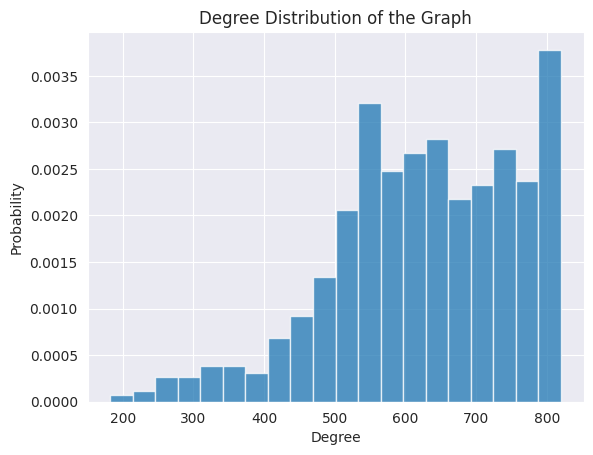

Graph with 821 nodes and 257296 edges
Avg. Shortest Path Length: 1.2356
Diameter: 2.0000
Sparsity: 0.7644
Global clustering coefficient aka Transitivity: 0.8229


In [12]:
# Plot the degree distribution
degree_sequence = [d for n, d in tqdm(tag_graph.degree())]
plt.hist(degree_sequence, bins=20, density=True, alpha=0.75)
plt.title("Degree Distribution of the Graph")
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.show()

# Describe the graph
describe_graph(tag_graph)

In [13]:
edges = tag_graph.edges.data('weight')
threshold = np.percentile([w for _, _, w in edges], 99.9)
filtered_edges = [(u, v, w) for u, v, w in edges if w > threshold]

filtered_graph = nx.Graph()  
filtered_graph.add_weighted_edges_from(filtered_edges)
print(filtered_graph)

Graph with 69 nodes and 258 edges


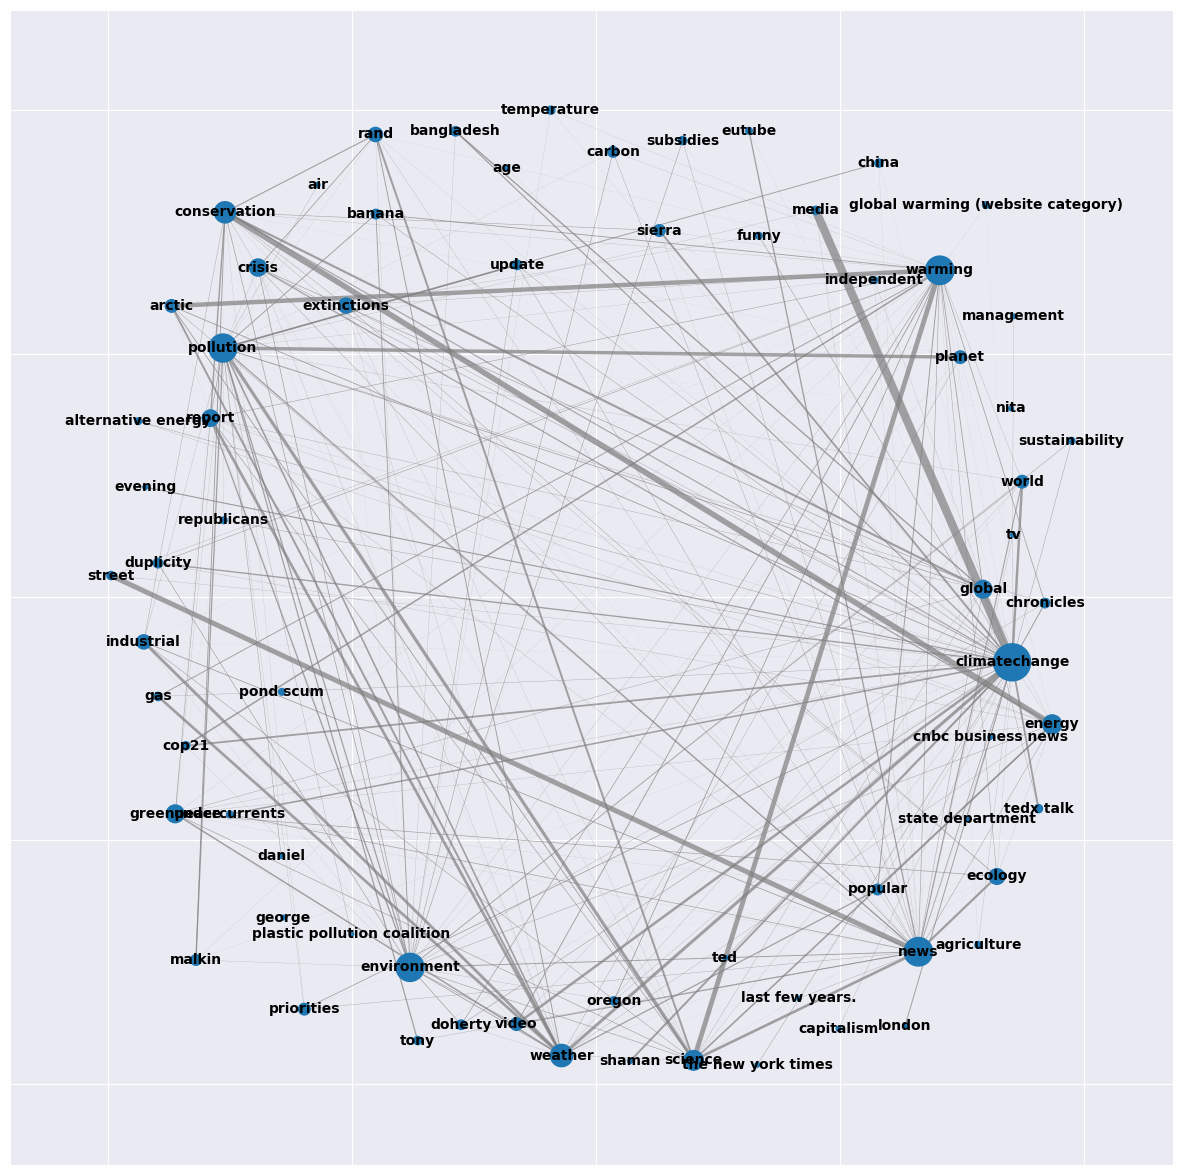

In [14]:
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(filtered_graph, k=1.1, iterations=20)  # Set the layout for bipartite graphs

weights = np.array([w for _, _, w in filtered_edges])
weights = (weights - weights.min()) / (weights.max() - weights.min() + 0.1) * 10  

degrees = np.array([d for _, d in filtered_graph.degree()]) 
degrees = degrees / (degrees.max() - degrees.min() + 0.1) * 700   # Min max normalize the degrees

nx.draw_networkx_nodes(filtered_graph, pos, node_size=degrees)
nx.draw_networkx_edges(filtered_graph, pos, width=weights, edge_color='gray', alpha=0.7)
nx.draw_networkx_labels(filtered_graph, pos, font_size=10, font_weight='bold')
plt.show()

In [15]:
data

display_id
rXVcnciIduc                    [science, climatechange, weather]
UhVk4R_T7O8    [dioxin, duplicity, duplicity, sierra, club, c...
RUjM59H3fYk    [global, warming, environment, world, jump, da...
MvTaLdk3-dE    [science, climatechange, global, warming, dist...
6otdzD8ncnw    [nrdc, environment, music, g.love, warming, en...
                                     ...                        
lZFBb6nOUyk                                             [carbon]
f9d7vRgiTjc    [water solar panels, coal-fired power plant, p...
uZLWfoHhf0M    [conservation, svs, oregon, conservation, malk...
XPSYzLZ7xKU    [seeker, science, crisis, extinctions, planet,...
WDo1uVuJmkg    [time magazine, robbie thorpe, agriculture, gl...
Name: tags, Length: 64629, dtype: object